In [ ]:
!pip install tensorflow
!pip install --upgrade tensorflow # for example
import os
import numpy as np
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils import class_weight
from tensorflow.keras.models import Model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andrewdslack","key":"dbfcbc6e5bc697a582b8076841dffbc7"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c platesv2

 87% 41.0M/47.0M [00:00<00:00, 72.3MB/s]
100% 47.0M/47.0M [00:00<00:00, 68.4MB/s]


In [ ]:
!unzip platesv2.zip

Archive:  platesv2.zip
  inflating: plates.zip              
  inflating: sample_submission.csv   


In [ ]:
!unzip plates.zip

Archive:  plates.zip
   creating: plates/
  inflating: plates/.DS_Store        
   creating: __MACOSX/
   creating: __MACOSX/plates/
  inflating: __MACOSX/plates/._.DS_Store  
   creating: plates/test/
  inflating: plates/test/0071.jpg    
  inflating: plates/test/0717.jpg    
  inflating: plates/test/0703.jpg    
  inflating: plates/test/0065.jpg    
  inflating: plates/test/0059.jpg    
  inflating: plates/test/0515.jpg    
  inflating: plates/test/0273.jpg    
  inflating: plates/test/0267.jpg    
  inflating: plates/test/0501.jpg    
  inflating: plates/test/0529.jpg    
  inflating: plates/test/0298.jpg    
  inflating: plates/test/0461.jpg    
  inflating: plates/test/0307.jpg    
  inflating: plates/test/0313.jpg    
  inflating: plates/test/0475.jpg    
  inflating: plates/test/0449.jpg    
  inflating: plates/test/0105.jpg    
  inflating: plates/test/0663.jpg    
  inflating: plates/test/0677.jpg    
  inflating: plates/test/0111.jpg    
  inflating: plates/test/0139.jpg    


In [ ]:
# Create an instance of ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the directory containing your training images
train_dir = '/content/plates/train'  # Replace with your training data directory

# Iterate through class subdirectories
for class_subdir in os.listdir(train_dir):
    if os.path.isdir(os.path.join(train_dir, class_subdir)):
        class_dir = os.path.join(train_dir, class_subdir)

    # Iterate through images in the class subdirectory
        for filename in os.listdir(class_dir):
          if filename.endswith((".jpg", ".png")):
            img_path = os.path.join(class_dir, filename)
            img = image.load_img(img_path, target_size=(256, 341))
            x = image.img_to_array(img)
            x = x.reshape((1,) + x.shape)

            # Generate and save augmented images in the same directory
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=class_dir,
                save_prefix=f'aug_{filename[:-4]}', save_format='jpeg'):
              i += 1
              if i >= 25:  # Adjust number of augmented images per original
                    break


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/plates/train',
    labels='inferred',
    label_mode='int',
    image_size=(256, 341),  # Set desired image size
    batch_size=32,
    validation_split=0.2,  # Split for validation
    subset='training',  # Specify 'training' for the training dataset
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/plates/train',
    labels='inferred',
    label_mode='int',
    image_size=(256, 341),  # Set desired image size
    batch_size=32,
    validation_split=0.2,  # Split for validation
    subset='validation',
    seed=123
)


# Preprocessing
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

train_ds = train_ds.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 1039 files belonging to 2 classes.
Using 832 files for training.
Found 1039 files belonging to 2 classes.
Using 207 files for validation.


In [ ]:
labels = []
for _, label in train_ds.unbatch():
    labels.append(label.numpy())

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

num_classes = 2

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 341, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 50  # Adjust as needed


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor (validation loss in this case)
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,
                    callbacks=[early_stopping, reduce_lr],
                    class_weight=class_weights)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 38s 294ms/step - accuracy: 0.6413 - loss: 2.0765 - val_accuracy: 0.5198 - val_loss: 2.0717 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.7705 - loss: 1.1309 - val_accuracy: 0.5858 - val_loss: 1.3094 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.8383 - loss: 0.7168 - val_accuracy: 0.6898 - val_loss: 0.9103 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.8693 - loss: 0.5273 - val_accuracy: 0.7574 - val_loss: 0.6304 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.8924 - loss: 0.4209 - val_accuracy: 0.7426 - val_loss: 0.6420 - learning_rate: 0.0010
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.9116 - loss: 0.3503 - val_accuracy: 0.7459 - val_loss: 0.6042 - learning_rate: 0.0010
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9136 - loss: 0.316

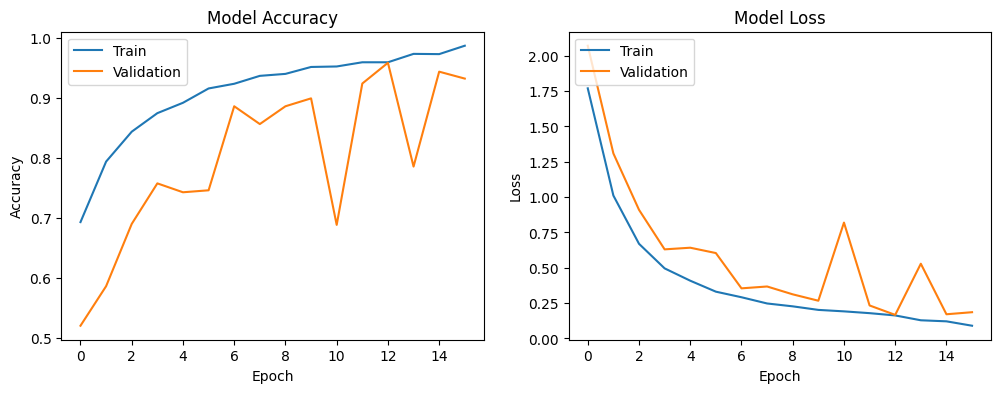

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy']) # Access history using history.history
plt.plot(history.history['val_accuracy']) # Access history using history.history
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss']) # Access history using history.history
plt.plot(history.history['val_loss']) # Access history using history.history
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.show()

In [ ]:
# Define the path to your unclassified images folder
unclassified_folder = '/content/plates/train/dirty'

# Get the class names
class_names = ['cleaned', 'dirty']

# Initialize a list to store predictions
predictions = []

# Loop through each image in the unclassified folder
for img_name in os.listdir(unclassified_folder):
    img_path = os.path.join(unclassified_folder, img_name)
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        img = image.load_img(img_path, target_size=(256, 341))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize the image

        # Predict the class
        prediction = model.predict(img_array)
        predicted_class = class_names[int(prediction > 0.5)]

        # Append the prediction
        predictions.append((img_name, predicted_class))
    else:
        print(f"Skipping non-image file: {img_name}")

# Print the predictions
for img_name, predicted_class in predictions:
    print(f'Image: {img_name}, Predicted Class: {predicted_class}')

In [ ]:

# Define the paths to your folders
cleaned_folder = '/content/plates/train/cleaned'
dirty_folder = '/content/plates/train/dirty'

# Get the number of files in each folder
num_cleaned_files = len(os.listdir(cleaned_folder))
num_dirty_files = len(os.listdir(dirty_folder))

# Print the results
print(f"Number of files in 'train/cleaned': {num_cleaned_files}")
print(f"Number of files in 'train/dirty': {num_dirty_files}")

Number of files in 'train/cleaned': 521
Number of files in 'train/dirty': 520
